In [1]:
# import pacakges that will be important later
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 


# load the data
df = pd.read_csv('cubingstats.csv')

df.head()

# the data that we want to predict is the third column. Everything else is the featureset

data = df.values

,age,experience,CFOP?,solves,inspection time,algs,CN?,proportion
0,22,10,1,80,10,200,1,0.454545
1,21,8,1,20,10,120,1,0.380952
2,18,6,1,100,10,600,1,0.333333
3,16,6,1,20,10,80,0,0.375
4,13,3,1,10,8,300,1,0.230769


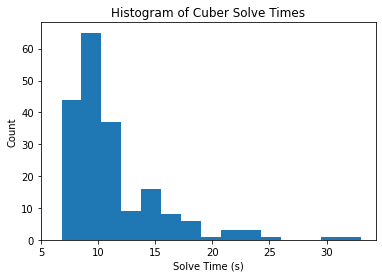

In [2]:
# Set inputs and outputs
Y = data[:,3]*1.0 # avg solve time
plt.hist(Y,bins=15)
plt.xlim(left=5)
plt.xlabel('Solve Time (s)')
plt.ylabel('Count')
plt.title('Histogram of Cuber Solve Times')


X = np.array(data[:,np.r_[1:3, 4:9]])
dummy = np.ones([X.shape[0],1])
# add a dummy column that we'll fill in later
X = np.append(X,dummy,axis=1)

# X is ordered by [age, years of experience, method, # solves/day, inspection time, # algs, color neutrality]

# Convert strings to more useful things. We'll use 1 for CFOP and 0 for not CFOP. We'll also convert the last column to 1's and 0's. You can use list comprehension for this step, but I'll use a for loop for readability (the data is small enough that it won't really affect runtime). 

for row in range(X.shape[0]):
    if X[row,2] == 'CFOP':
        X[row,2] = 1
    else:
        X[row,2] = 0
    
    if X[row,6] == 'Yes':
        X[row,6] = 1
    else:
        X[row,6] = 0

    # Let's add a new metric that says what proportion of a person's life has been involved with cubing. 
    X[row,7] = X[row,1]/X[row,0]

X_preprocessed = X*1.0

pd.DataFrame(X_preprocessed, columns=['age','experience','CFOP?','solves','inspection time','algs','CN?','proportion']).head() # print the first few rows of the new array



Looks like most people are pretty fast!

The data we're working with is not particularly complex, but it seems unlikely that people's solve times are simply a linear combination of the features. We'll use a neural network (which has its own set of issues, but we can address those later).


In [36]:
# First we need to generate training and testing sets
from sklearn import preprocessing 
# we'll use MinMaxScaler to confine the values for each entry to be between 0 and 1
scaler_x = preprocessing.MinMaxScaler().fit(X_preprocessed)
scaler_y = preprocessing.MinMaxScaler().fit(Y.reshape(-1,1))
X_scale = scaler_x.transform(X_preprocessed)
Y_scale = scaler_y.transform(Y.reshape(-1,1))

print(pd.DataFrame(X_scale).head()) # print the first five rows

from sklearn.model_selection import train_test_split

# We'll use 20% of the data for validating and testing
X_train, X_test, Y_train, Y_test = train_test_split(X_scale, Y_scale, test_size = 0.30)


0         1    2         3         4         5    6         7
0  0.270270  0.454545  1.0  0.266667  0.545455  0.088608  1.0  0.606061
1  0.243243  0.363636  1.0  0.066667  0.545455  0.048101  1.0  0.507937
2  0.162162  0.272727  1.0  0.333333  0.545455  0.291139  1.0  0.444444
3  0.108108  0.272727  1.0  0.066667  0.545455  0.027848  0.0  0.500000
4  0.027027  0.136364  1.0  0.033333  0.363636  0.139241  1.0  0.307692


## Model Training

Great, now we have our dataset preprocessed and it's time to create a neural network model. We'll be using Keras for this because of the straightforward implementation, but other packages can be used too.


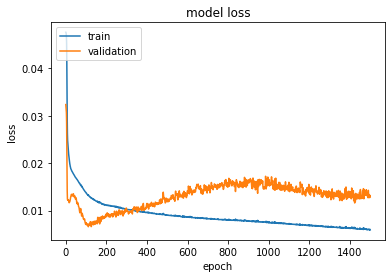

In [68]:
from keras.models import Sequential
from keras.layers import Dense 
from sklearn.model_selection import cross_val_score, KFold
from keras.wrappers.scikit_learn import KerasRegressor

# We'll create a model that has 30 neurons in the two hidden layers, and 1 neuron for the output layer. 

model = Sequential([
    Dense(6, activation = 'relu', input_dim=X_preprocessed.shape[1]),
    Dense(6, activation = 'relu'),
    Dense(6, activation = 'relu'),
    Dense(1, activation = 'relu'),
])

model.compile(loss='mean_squared_error', optimizer = 'adam', metrics = ['mse','mae'])

# Time to train! It's super easy with Keras
history = model.fit(X_train, Y_train, epochs = 1500, batch_size = 32, verbose = 0, validation_split = 0.2)

# Plot the Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [69]:
# make some prediction
# [age, years of experience, method, # solves/day, inspection time, # algs, color neutrality]
age = 26
exp = 1
method = 1
solves = 0
inspection_time = 10
algs = 125
cn = 0
prop = exp/age

Xnew = np.array([[age, exp, method, solves, inspection_time, algs, cn, prop]])
Xnew= scaler_x.transform(Xnew)
ynew= model.predict(Xnew)
#invert normalize
ynew = scaler_y.inverse_transform(ynew) 
Xnew = scaler_x.inverse_transform(Xnew)
print("X=%s, Predicted=%s" % (Xnew[0], ynew[0]))

X=[2.60000000e+01 1.00000000e+00 1.00000000e+00 0.00000000e+00
 1.00000000e+01 1.25000000e+02 0.00000000e+00 3.84615385e-02], Predicted=[20.537676]


The results are suuuuper interesting, but let's see if we can find more concrete trends. If we hold all but one parameter constant, we can get a rough feel for where the minima are for each parameter. Note: replacing each parameter with these "optimimum" values does NOT necessarily lead to the fastest solve times. The model is nonlinear! If we expected the minima for each parameter to lead to a combination of parameters that would give us the fastest solve times, we would have used a linear model.


In [74]:
# How inspection time affects solve times
%matplotlib qt

meanx = np.array([np.mean(X,axis=0)])
res = []
for insp_time in range(16):
    meanx[0,4] = insp_time
    Xnew= scaler_x.transform(meanx)
    ynew= model.predict(Xnew)
    #invert normalize
    ynew = scaler_y.inverse_transform(ynew) 
    res.append(ynew[0])

plt.figure(figsize=(10,10))
plt.subplot(221)
plt.plot(X[:,4],Y,'.')
plt.plot(np.arange(0,16), res, c='orange')
plt.legend(['Actual Data', 'Model Predictions'])
plt.xlabel('Inspection Time (s)')
plt.ylabel('Solve Time (s)')
plt.title('Inspection Time')

# Algs
meanx = np.array([np.mean(X,axis=0)])
meanx[:,2]=1
res = []
for algs in range(2001):
    meanx[0,5] = algs
    Xnew= scaler_x.transform(meanx)
    ynew= model.predict(Xnew)
    #invert normalize
    ynew = scaler_y.inverse_transform(ynew) 
    res.append(ynew[0])

plt.subplot(222)
plt.plot(X[:,5],Y,'.')
plt.plot(np.arange(0,2001), res, c='orange')
plt.xlabel('# Algorithms')
plt.title('Number of Algs Known')

# Age
meanx = np.array([np.mean(X,axis=0)])
res = []
for age in range(50):
    meanx[0,0] = age
    Xnew= scaler_x.transform(meanx)
    ynew= model.predict(Xnew)
    #invert normalize
    ynew = scaler_y.inverse_transform(ynew) 
    res.append(ynew[0])

plt.subplot(223)
plt.plot(X[:,0],Y,'.')
plt.plot(np.arange(0,50), res, c='orange')
plt.xlim(left=10)
plt.xlabel('Age')
plt.ylabel('Solve Time (s)')
plt.title('Age')

# Proportion of Years Spent Cubing
meanx = np.array([np.mean(X,axis=0)])
res = []
for exp in range(100):
    meanx[0,7] = exp/100.
    Xnew= scaler_x.transform(meanx)
    ynew= model.predict(Xnew)
    #invert normalize
    ynew = scaler_y.inverse_transform(ynew) 
    res.append(ynew[0])

plt.subplot(224)
plt.plot(X[:,7],Y,'.')
plt.plot(np.arange(0,1,step=0.01), res, c='orange')
plt.xlabel('Experience/Age')
plt.xlim(0,0.8)
plt.title('Proportion of Years Cubing')
plt.show()

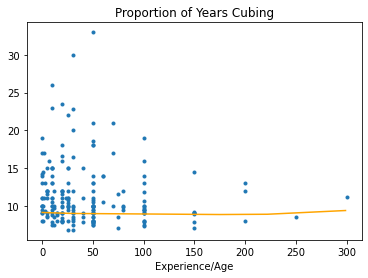

In [73]:
# Proportion of Years Spent Cubing
meanx = np.array([np.mean(X,axis=0)])
res = []
for solves in range(300):
    meanx[0,3] = solves
    Xnew= scaler_x.transform(meanx)
    ynew= model.predict(Xnew)
    #invert normalize
    ynew = scaler_y.inverse_transform(ynew) 
    res.append(ynew[0])

plt.plot(X[:,3],Y,'.')
plt.plot(np.arange(0,300), res, c='orange')
plt.xlabel('Experience/Age')
plt.title('Proportion of Years Cubing')
plt.show()

Text(0, 0.5, 'Algorithms Known')

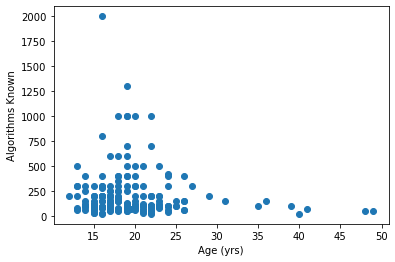

In [5]:
plt.scatter(X[:,0],X[:,5])
plt.xlabel('Age (yrs)')
plt.ylabel('Algorithms Known')